# Introduction to Pamap2 dataset
This code visualizes the dataset and segment it into sliding windows.

By Juan Felipe Vargas Colorado and Bo Zhou

# Setting things up
add a shortcut to this following folder into your own google drive:
https://drive.google.com/drive/folders/1hMByHFDsgCx-iCED3Z1WccOh690c84ew?usp=sharing
The first few lines of this code will mount your drive and read the data via the shortcut. You may need to authorize Colab to read your Drive, just follow the code's output instructions.

# PAMAP2 Dataset structure

* 1 -> timestamp (s)
* 2 -> activityID (see II.2. for the mapping to the activities)
* 3 -> heart rate (bpm)
* 4 - 20 -> IMU hand
* 21 - 37 -> IMU chest
* 38 - 54 -> IMU ankle

## IMU Data structure
The IMU sensory data was recorded with a frequency of 100Hz and contains the following columns:
* 1 -> temperature (°C)
* 2 - 4 -> 3D-acceleration data (ms -2 ),  scale: ±16g, resolution: 13-bit
* 5 - 7 -> 3D-acceleration data (ms -2 ),  scale: ±6g, resolution: 13-bit *
* 8 - 10 -> 3D-gyroscope data (rad/s)
* 11 - 13 -> 3D-magnetometer data (μT)
* 14 - 17 -> orientation (invalid in this data collection)

## Activity definitions
The corresponding IDs for the activities are:
* 0 -> other (transient activities)
* 1 -> lying
* 2 -> sitting
* 3 -> standing
* 4 -> walking
* 5 -> running
* 6 -> cycling
* 7 -> Nordic walking
* 9 -> watching TV
* 10 -> computer work
* 11 -> car driving
* 12 -> ascending stairs
* 13 -> descending stairs
* 16 -> vacuum cleaning
* 17 -> ironing
* 18 -> folding laundry
* 19 -> house cleaning
* 20 -> playing soccer
* 24 -> rope jumping




# Program description
This program can be used to separate the data provided in the PAMAP2 dataset into different time windows.

The default value for Window size is 2 seconds with a step size of 0.5 seconds. 

The default file for data extraction is Protocol/subject101.dat 

In [ ]:
# Import the libraries
import numpy as np
import pandas as pd
import glob, os
from sklearn.impute import SimpleImputer

import seaborn as sns
import matplotlib.pyplot as plt
# Define style for plotting
plt.style.use('seaborn-darkgrid')

In [ ]:
# Import files from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy protocol files from drive to the content folder
# this may take a while
!cp -r "/content/drive/My Drive/PAMAP2_Dataset/Protocol" .

In [ ]:
# These are the "Tableau 20" colors as RGB for plotting.   
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

# Default file names
fileName = "Protocol/subject101.dat"
outputFile = fileName.replace(".dat","")

# Default columns to extract from Dataset
cols = [0,4,5,6] # Timestamp + 3D Acceleration Hand 

# Define default window size and time step in seconds
windowSize = 2    # (seconds)
windowStep = 0.5  # (seconds)

In [ ]:
# Replace Nan values in data
def replaceNan (data):
    # Use median as strategy to replace nan values 
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    # Fit data excluding the first column (timestamp)
    imputer.fit(data[:, 1:])    
    data[:, 1:] = imputer.transform(data[:, 1:])

##Observe the data

Plot the data with the annotations overlapping

In [ ]:
# Import the dataset
dataset = pd.read_csv(fileName, header=None, sep=' ') 

X = dataset.iloc[:, cols].values
y = dataset.iloc[:, 1].values # Activity labels

print("X shape: ",X.shape)
print("y shape: ",y.shape)

# Check if there are Nan values in the dataset
nanCount = np.isnan(X).sum()
print(nanCount," Nan values")

# Taking care of missing data (Nan)
print("Replacing Nan values ...")
replaceNan(X)

# Check again if there are Nan values in the dataset
nanCount = np.isnan(X).sum()
print(nanCount," Nan values")

X shape:  (376417, 4)
y shape:  (376417,)
4362  Nan values
Replacing Nan values ...
0  Nan values


In [ ]:
def plot_fulldata(data, labels, regioncolors):
    # Define the upper limit, lower limit, interval of Y axis and colors
    y_LL = int( np.amin(data[:,1:])*1.1)
    y_UL = int( np.amax(data[:,1:])*1.1)
    y_interval = 10
    mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']  


    fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80) 
    columns = data.shape[1]-1

    # Draw Plot for each column in data
    for column in range(columns):
        plt.plot(data[:,0], data[:,column+1], lw=1.5, color=mycolors[column])    


    # Draw Tick lines  
    for ylin in range(y_LL, y_UL, y_interval):    
        plt.hlines(ylin, xmin=0, xmax=data[-1,0], colors='white', alpha=1, linestyles="--", lw=1.5)

    # Decorations    
    plt.tick_params(axis="both", which="both", bottom=False, top=False,    
                    labelbottom=True, left=False, right=False, labelleft=True) 

    # Lighten borders
    plt.gca().spines["top"].set_alpha(.3)
    plt.gca().spines["bottom"].set_alpha(.3)
    plt.gca().spines["right"].set_alpha(.3)
    plt.gca().spines["left"].set_alpha(.3)

    plt.title('Physical Activity Monitoring for %s'%(fileName.replace(".dat","").replace("Protocol/","")), fontsize=22)
    plt.yticks(range(y_LL, y_UL, y_interval), [str(y) for y in range(y_LL, y_UL, y_interval)], fontsize=12)    
    plt.xlabel('Time (s)')
    plt.ylabel('3D-acceleration data($ms^{-2}$)')  
    plt.ylim(y_LL, y_UL)    
    plt.xlim(0, data[-1,0]) 

    # Detect a change of activities
    label_ch = np.where(np.diff(labels) != 0)[0]
    # Add extreme values (0 and data size)
    label_ch = np.insert(label_ch,0,0)
    label_ch = np.append(label_ch,data[:,0].shape[0]-1)  

    # New list to store plotted labels
    ex_label = []

    #Color the regions according to the activity
    for reg in range (len(label_ch)-1):
        # Find the corresponding color to the activity
        colour = regioncolors[labels[label_ch[reg+1]]]
        # Detect if the label is repeated
        activity_id = labels[label_ch[reg+1]]
        if activity_id in ex_label:
            lab = "_"
        else:
            ex_label.append(activity_id)
            lab = activity_id
        # Fill the corresponding region with color
        ax.axvspan(data[label_ch[reg],0], data[label_ch[reg+1],0], alpha=0.5, color=colour,label=lab)

    # Get the labels and handles to sort them according to the activity ID
    xhandles, xlabels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    xlabels, xhandles = zip(*sorted(zip(xlabels, xhandles), key=lambda x: int(''.join(filter(str.isdigit, x[0])))))
    ax.legend(xhandles, xlabels,title="Activity IDs", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    plt.show()

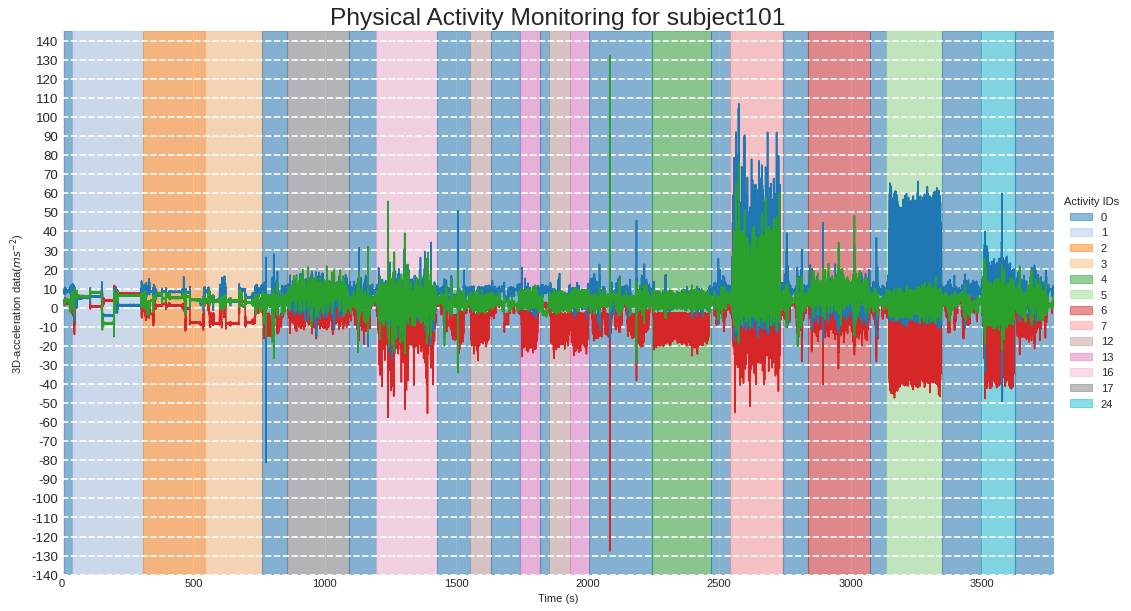

In [ ]:
# Create list with the activity IDs of dataset
activities = [0,1,2,3,4,5,6,7,9,10,11,12,13,16,17,18,19,20,24]

# Assign one color to each activity
regioncolors = {activities[i]: tableau20[i] for i in range(len(activities))}

plot_fulldata(X,y,regioncolors)


# Split the data

In [ ]:
# Split data into windows     
def splitInWindows (data,labels, wSize, wStep):
    # Divide data according to the different activities
    X_activities = np.split(data, np.where(np.diff(labels) != 0)[0]+1)
    y_activities = labels[np.where(np.diff(labels) != 0)[0]]
    
    print("X list shape ", len(X_activities))
    print("y list shape ", len(y_activities))

    for activity in range(0,len(X_activities)):
      print("X shape in activity ", activity, X_activities[activity].shape)

    # Add the label of the last activity
    y_activities = np.append(y_activities,labels[-1])
    
    # how fast is the sample rate?
    m_samplerate = np.round(1/np.diff(data[:,0]).mean())
    print("sampling rate", m_samplerate)

    # Convert size of window and time step into data points
    m_windowsize = int(m_samplerate * wSize)
    m_windowstep = int(m_samplerate * wStep)

    # Store windows
    X_window = []
    y_window = []

    # Divide data in windows
    for activity in range(0,len(X_activities)):
        for wind in range(0,int((X_activities[activity].shape[0]-m_windowsize)/m_windowstep)):
            m_window_data = X_activities[activity][wind*m_windowstep : wind*m_windowstep+m_windowsize]
            X_window.append(m_window_data)
            y_window.append(y_activities[activity])
    X_window = np.stack(X_window)
    y_window = np.stack(y_window)
    
    return X_window, y_window, m_samplerate


In [ ]:
# Split Data into sliding windows
X_w, Y_w, srate = splitInWindows(X,y,windowSize,windowStep)

# Visualize data shape (windows, samples, channels)
print("Data shape ", X_w.shape)
print("Labels shape ", Y_w.shape)

X list shape  26
y list shape  25
X shape in activity  0 (2928, 4)
X shape in activity  1 (27187, 4)
X shape in activity  2 (23480, 4)
X shape in activity  3 (21717, 4)
X shape in activity  4 (9655, 4)
X shape in activity  5 (23573, 4)
X shape in activity  6 (10220, 4)
X shape in activity  7 (22941, 4)
X shape in activity  8 (12580, 4)
X shape in activity  9 (8120, 4)
X shape in activity  10 (10995, 4)
X shape in activity  11 (7480, 4)
X shape in activity  12 (3686, 4)
X shape in activity  13 (7770, 4)
X shape in activity  14 (7419, 4)
X shape in activity  15 (24008, 4)
X shape in activity  16 (22253, 4)
X shape in activity  17 (7163, 4)
X shape in activity  18 (20265, 4)
X shape in activity  19 (9656, 4)
X shape in activity  20 (23575, 4)
X shape in activity  21 (6071, 4)
X shape in activity  22 (21265, 4)
X shape in activity  23 (14881, 4)
X shape in activity  24 (12912, 4)
X shape in activity  25 (14617, 4)
sampling rate 100.0
Data shape  (7413, 200, 4)
Labels shape  (7413,)


**Let's see the seperated windows from different classes**

In [ ]:
def plot_windows(data,labels,srate,numcolumns,window):
    # Identify indices when there is a change of activities 
    label_ch = np.where(np.diff(labels) != 0)[0]
    # Add corresponding activity label to the index
    label_ch = np.column_stack((label_ch,labels[np.where(np.diff(labels) != 0)[0]]))
    # Find the different types of activities performed by the person
    activityLabels = np.unique(labels)
    # Remove Activity 0 (transient activities) 
    activityLabels = np.delete(activityLabels,np.where(activityLabels == 0))

    # Define the number of columns and rows to visualize data
    row = int(np.ceil(len(activityLabels)/numcolumns))

    # Set the time axis 
    time = np.linspace(0,data.shape[1]/srate,data.shape[1],endpoint=False)

    # Plot windows for each activity
    fig, axs = plt.subplots(row,numcolumns,figsize=(15,10),sharex=True)

    for act in range(len(activityLabels)):
        indx = int(act / numcolumns)
        indy = act % numcolumns
        index_act = label_ch[np.argwhere(label_ch == activityLabels[act])[0][0]][0]  
        axs[indx,indy].plot(time,data[index_act+window,:,1:])
        axs[indx,indy].set_title('Activity ID - %d'%(activityLabels[act]), fontsize=12)
    fig.suptitle('Window %d for different activities of %s'%(window,fileName.replace(".dat","").replace("Protocol/","")),fontsize=22)
    fig.text(0.5, 0.08, 'Time (s)', ha='center')
    fig.text(0.08, 0.5, '3D-acceleration data($ms^{-2}$)', va='center', rotation='vertical')
    plt.show()




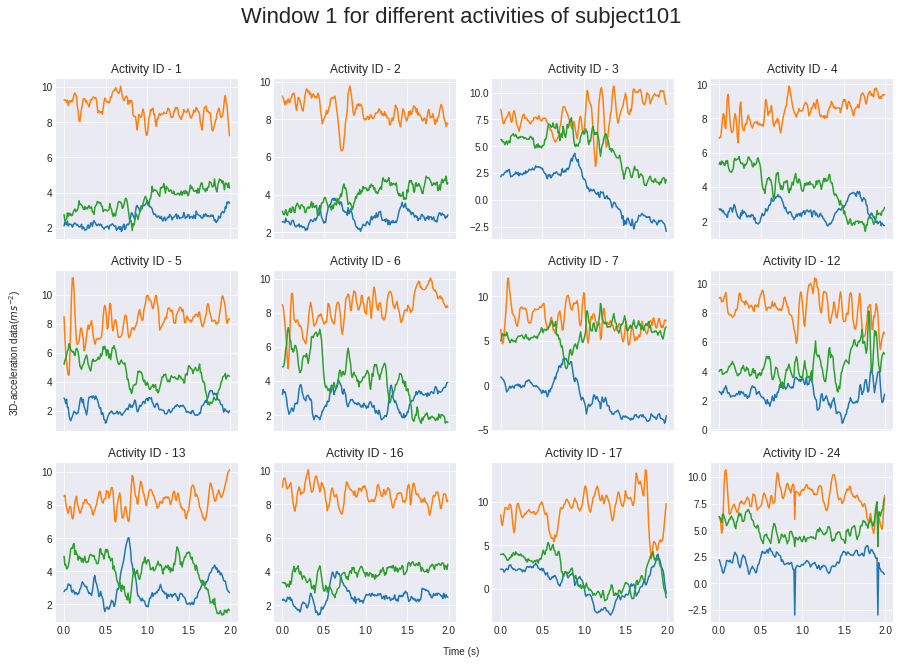

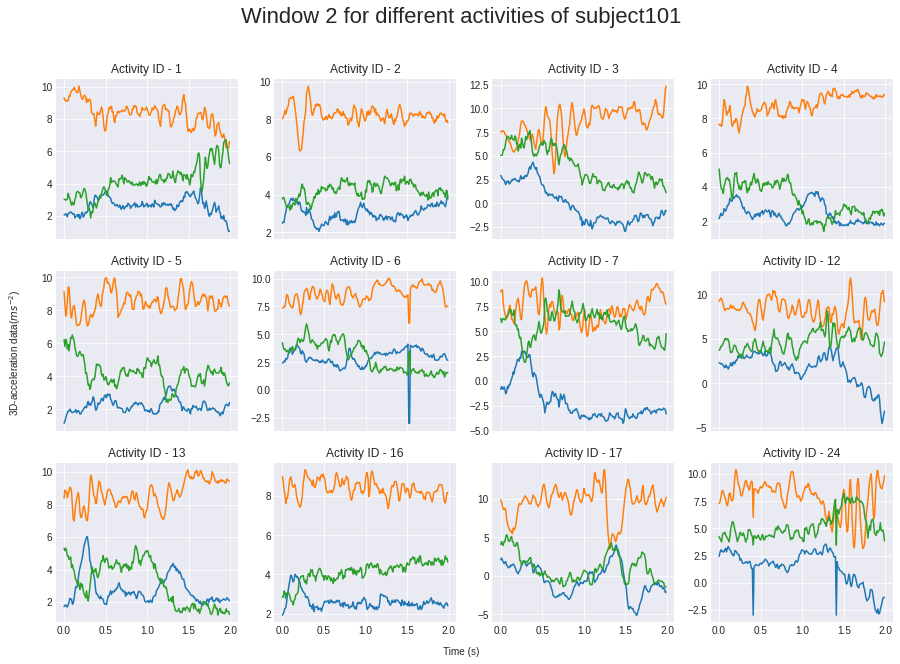

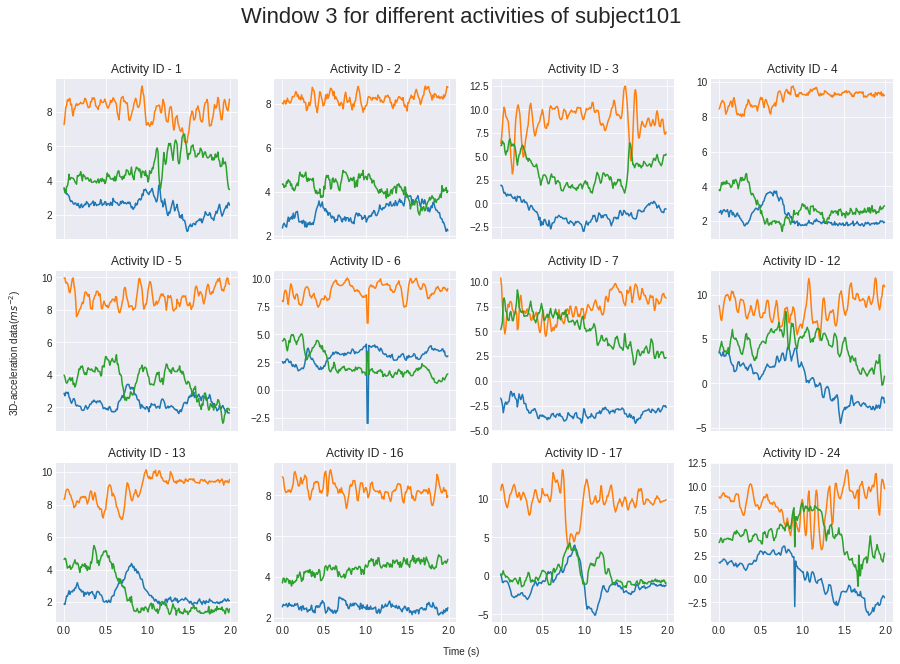

In [ ]:
# Define the number of columns to plot data
col = 4
# Which window you want to visualize
window = 1

# Plot some windows
plot_windows(X_w, Y_w, srate,col,window)
plot_windows(X_w, Y_w, srate,col,2)
plot_windows(X_w, Y_w, srate,col,3)

In [ ]:
# Save data 
np.savez(outputFile,X_w,Y_w)
print("File saved to", outputFile)

File saved to Protocol/subject101


In [ ]:
# Load data
data = np.load("Protocol/subject101.npz")
X = data['arr_0']
y = data['arr_1']

print("Data shape ", X.shape)
print("Labels shape ", y.shape)

Data shape  (7413, 200, 4)
Labels shape  (7413,)


In [ ]:
# Split data for all the .dat files in a folder
def splitFolderData(Folder):
    search = Folder + "/" + "*.dat"
    for file in glob.glob(search):
        print("Opening file: ", file)
        outputFile = file.replace(".dat","")
        dataset = pd.read_csv(file, header=None, sep=' ') 

        X = dataset.iloc[:, cols].values
        y = dataset.iloc[:, 1].values # Activity labels

        print("\nX shape: ",X.shape)
        print("y shape: ",y.shape)

        print("\nDealing with Nan Values ...\n")
        # Check if there are Nan values in the dataset
        nanCount = np.isnan(X).sum()
        print("Found ", nanCount," Nan values")

        # Taking care of missing data (Nan)
        print("Replacing Nan values ...")
        replaceNan(X)

        # Check again if there are Nan values in the dataset
        nanCount = np.isnan(X).sum()
        print("Found ", nanCount," Nan values after preprocessing.\n")

        # Split Data into sliding windows
        print("Splitting data into windows of %5.2f seconds with an overlap of %5.2f seconds"%(windowSize,windowStep))
        X_w, Y_w,_ = splitInWindows(X,y,windowSize,windowStep)

        # Visualize data shape (windows, samples, channels)
        print("Data shape ", X_w.shape)
        print("Labels shape ", Y_w.shape)

        # Save data 
        np.savez(outputFile,X_w,Y_w)
        print("\nFile saved to", outputFile,"\n")

In [ ]:
# Test with all the folders
splitFolderData("Protocol")

Opening file:  Protocol/subject106.dat

X shape:  (361817, 4)
y shape:  (361817,)

Dealing with Nan Values ...

Found  3063  Nan values
Replacing Nan values ...
Found  0  Nan values after preprocessing.

Splitting data into windows of  2.00 seconds with an overlap of  0.50 seconds
X list shape  25
y list shape  24
X shape in activity  0 (9588, 4)
X shape in activity  1 (23340, 4)
X shape in activity  2 (5347, 4)
X shape in activity  3 (23041, 4)
X shape in activity  4 (24356, 4)
X shape in activity  5 (37744, 4)
X shape in activity  6 (7467, 4)
X shape in activity  7 (21078, 4)
X shape in activity  8 (13309, 4)
X shape in activity  9 (6232, 4)
X shape in activity  10 (10106, 4)
X shape in activity  11 (6173, 4)
X shape in activity  12 (8338, 4)
X shape in activity  13 (7059, 4)
X shape in activity  14 (5099, 4)
X shape in activity  15 (22126, 4)
X shape in activity  16 (25721, 4)
X shape in activity  17 (7917, 4)
X shape in activity  18 (26686, 4)
X shape in activity  19 (8551, 4)
X sh